# Using pyHalo with lenstronomy to create mock lensed images 

### This notebook is a short demo for how to lensed images that includes perturbations from substructure. This notebook shows how to create a realization that is aligned with the path traversed by the light in a lens system, an extension of what is shown in the notebook "example_generating_realizations". 

### The procedure followed in notebook is totally general and could be applied to any lens/source configuration with halos in the lens model. To demonstrate a feature of pyHalo that shifts halos to track the path of a lensed light ray, I will create a lens system that has a large galaxy between the main deflector and the source

In [1]:
from pyHalo.pyhalo import pyHalo
import numpy as np
from time import time
import matplotlib.pyplot as plt

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel

### The cell below is more or less the same as the one in "example_generating_realizations", look there for documentation

In [2]:
zlens, zsource = 0.5, 1.5
cone_opening_angle = 6.
rendering_volume = 'DOUBLE_CONE' 
kwargs_halo_mass_function = {'geometry_type': rendering_volume}
mass_definition = 'TNFW' 
log_mlow = 7. 
log_mhigh = 10 
power_law_index = -1.9 
LOS_norm = 1. 
sigma_sub = 0.02 
r_tidal = '0.25Rs' 
log_m_host = 13.

log_mass_sheet_min = 6
log_mass_sheet_max = 10

pyhalo = pyHalo(zlens, zsource, kwargs_halo_mass_function=kwargs_halo_mass_function)

realization_kwargs = {'mass_func_type': 'POWER_LAW', 'log_mlow': log_mlow, 'log_mhigh': log_mhigh, 
                      'log_mass_sheet_min': log_mlow, 'log_mass_sheet_max': log_mhigh, 
                      'mdef_main': mass_definition,'mdef_los': mass_definition, 'sigma_sub': sigma_sub,
                      'cone_opening_angle': cone_opening_angle, 
                      'log_m_host': log_m_host, 'power_law_index': power_law_index, 'r_tidal': r_tidal,
                      'LOS_normalization': LOS_norm}

realization_type = 'composite_powerlaw'
astropy_instance = pyhalo.astropy_cosmo
realization_init = pyhalo.render(realization_type, realization_kwargs, nrealizations=1)[0]
lens_model_list, lens_redshift_array, kwargs_halos, _ = realization_init.lensing_quantities()

### We can now create a lens model that includes halos. I will include a galaxy in between the main deflector and the source, which deflects the light before it reaches the main lens plane. This often results in source positions that are significantly offset from the origin. 

In [3]:
kwargs_macromodel = [{'theta_E': 1., 'center_x': 0., 'center_y': 0., 'e1': 0.2, 'e2': 0., 'gamma': 2.},
                    {'gamma1': 0.08, 'gamma2': 0.},
                    {'theta_E': 1.3, 'center_x': 1.6, 'center_y': 0.}]

lens_model_list_macro = ['EPL', 'SHEAR', 'SIS']
delta_z = 0.4
redshift_list_macro = [zlens, zlens, zlens + delta_z]
lens_model_list_full = lens_model_list_macro + lens_model_list
lens_redshift_list_full = redshift_list_macro + list(lens_redshift_array)
kwargs_lens_full = kwargs_macromodel + kwargs_halos

lens_model_macro = LensModel(lens_model_list_macro, zlens, zsource, redshift_list_macro, 
                             cosmo=astropy_instance, multi_plane=True)

lens_model_full = LensModel(lens_model_list_full, zlens, zsource, lens_redshift_list_full, cosmo=astropy_instance, multi_plane=True)

### Now we will choose a source position, and shift the halos such that they track the path of the light. This is a straight line from the observer to the main deflector mass centroid, and then a deflected path from the main deflector mass centroid to the source position

In [4]:
source_x, source_y = lens_model_macro.ray_shooting(1.2, 0., kwargs_macromodel)
print(source_x, source_y)
x_center_lens = [kwargs_macromodel[0]['center_x']]
y_center_lens = [kwargs_macromodel[0]['center_y']]

# ray_angles_x, ray_angles_y return a list of of scipy.interp1d for the angular position of a ray 
# given a comoving distance; it will be a list the same length as x_center_lens/y_center_lens
ray_angles_x, ray_angles_y = pyhalo.interpolate_ray_paths(x_center_lens, y_center_lens, lens_model_macro, 
                        kwargs_macromodel, zsource, terminate_at_source=True, source_x=source_x, source_y=source_y)

1.4826554334381268 0.0


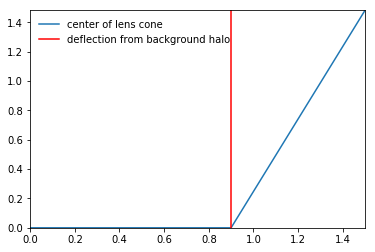

In [5]:
comoving_distances = [0,
                      astropy_instance.comoving_transverse_distance(zlens).value, 
                      astropy_instance.comoving_transverse_distance(zlens + delta_z).value, 
                      astropy_instance.comoving_transverse_distance(zsource).value]

plt.plot([0, zlens, zlens + delta_z, zsource], ray_angles_x[0](comoving_distances), label='center of lens cone')
plt.gca().axvline(zlens + delta_z, label='deflection from background halo', color='r')
plt.xlim(0, zsource)
plt.ylim(0, source_x)
plt.legend(frameon=False)

### Now we will align the halos we've created with the path traversed by the light. In the figure below, red dots show the original realization created by pyhalo. The black dotes are shifted along the path traversed by the light tracking the rays from the observer through the center of the lens, past a background galaxy, to the source. 

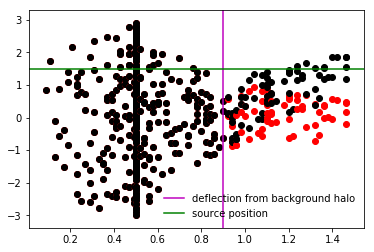

In [6]:
# Note: each realization can only be shifted like this once
realization = realization_init.shift_background_to_source(ray_angles_x[0], ray_angles_y[0])

for zi in realization.unique_redshifts:
    halos_shifted_at_z, _ = realization.halos_at_z(zi)
    halos_init_at_z, _ = realization_init.halos_at_z(zi)
    x_shifted = [halo.x for halo in halos_shifted_at_z]
    x_init = [halo.x for halo in halos_init_at_z]
    plt.scatter([zi]*len(halos_init_at_z), x_init, color='r')
    plt.scatter([zi]*len(halos_shifted_at_z), x_shifted, color='k')
plt.gca().axvline(zlens + delta_z, label='deflection from background halo', color='m')
plt.gca().axhline(source_x, label='source position', color='g')
plt.legend(frameon=False, loc=4)
    

#### This was a pretty extreme example - most lenses don't have massive galaxies behind them, but some do. Regardless, if you use the method shift_background_to_source you'll be able to deal with these situations

## To create a lensed image, we just have to define a source light model and put it at the source position

In [9]:
light_model_source = LightModel(['SERSIC_ELLIPSE'])
kwargs_light_source = [{'amp': 500, 'center_x': source_x, 'center_y': source_y, 
                 'e1': -0.3, 'e2': 0.1, 'n_sersic': 4., 'R_sersic': 1}]

light_model_lens = LightModel(['SERSIC_ELLIPSE'])
kwargs_light_lens = [{'amp': 1000, 'center_x': 0., 'center_y': 0., 
                 'e1': -0.3, 'e2': 0.1, 'n_sersic': 4., 'R_sersic': 1.45}]

npix = 80 
_x = _y = np.linspace(-1.5, 1.5, npix)
xx, yy = np.meshgrid(_x, _y)
shape0 = xx.shape

beta_x, beta_y = lens_model_full.ray_shooting(xx.ravel(), yy.ravel(), kwargs_lens_full)
lensed_source = light_model_source.surface_brightness(beta_x, beta_y, kwargs_light_source).reshape(shape0)
lens_light = light_model_lens.surface_brightness(xx.ravel(), yy.ravel(), kwargs_light_lens).reshape(shape0)
lensed_image = lens_light + lensed_source

beta_x_nohalos, beta_y_nohalos = lens_model_macro.ray_shooting(xx.ravel(), yy.ravel(), kwargs_macromodel)
lensed_source_nohalos = light_model_source.surface_brightness(beta_x_nohalos, beta_y_nohalos, kwargs_light_source).reshape(shape0)
lensed_image_nohalos = lens_light + lensed_source_nohalos

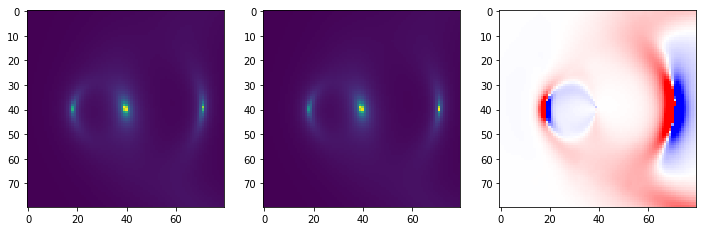

In [18]:
fig = plt.figure(1)
fig.set_size_inches(12, 8)
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)
ax1.imshow(lensed_image)
ax2.imshow(lensed_image_nohalos)

# THIS IS PURELY FOR DEMONSTRATION PURPOSES, YOU SHOULD ALWAYS RE-FIT THE LENS MODEL AFTER ADDING HALOS
# !!! NEVER DO THIS!!!
ax3.imshow(lensed_image- lensed_image_nohalos, cmap='bwr', vmin=-500, vmax=500)

In [ ]:
##